# Error Bar Illustration

In [112]:
from datetime import datetime
from matplotlib import dates as mdates
from matplotlib import pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skewnorm

sns.set()

In [113]:
time_range = (pd.Timestamp("2010-05-13 0:00:00"), pd.Timestamp("2010-06-01 00:00:00"))

In [114]:
# Read from Disk
df_dataset = pd.read_csv(
    "../data/processed/skew_gaussian/k200/delta_window8/processed_daysahead3_R000.csv"
)
df_dataset.forward_time = pd.to_datetime(df_dataset.forward_time)

# Subset
df_dataset = df_dataset[df_dataset.forward_time.between(*time_range)]

# Print
df_dataset.head()

,current_time,forward_time,forward_Vp_pred,forward_Vp_obs,forward_mean,forward_sigma,forward_skew,forward_crps
498,2010-05-10 06:00:00,2010-05-13 00:00:00,475.233333,448.28,0.0,105.149238,-0.840153,27.314170
499,2010-05-10 12:00:00,2010-05-13 06:00:00,454.033333,414.89,0.0,99.297648,-0.662699,29.282699
500,2010-05-10 18:00:00,2010-05-13 12:00:00,438.600000,380.22,0.0,94.019477,-0.578296,35.986275
501,2010-05-11 00:00:00,2010-05-13 18:00:00,422.000000,380.81,0.0,97.533113,-0.423116,29.631380
502,2010-05-11 06:00:00,2010-05-14 00:00:00,406.100000,358.60,0.0,102.439848,-0.195671,32.572317


In [115]:
err1 = []
err2 = []

for _, row in df_dataset.iterrows():
    dist = skewnorm(
        row.forward_skew,
        loc=row.forward_Vp_pred + row.forward_mean,
        scale=row.forward_sigma,
    )
    err1.append(dist.interval(0.75))
    err2.append(dist.interval(0.95))

err1 = np.array(err1)
err2 = np.array(err2)
err1.shape

(77, 2)

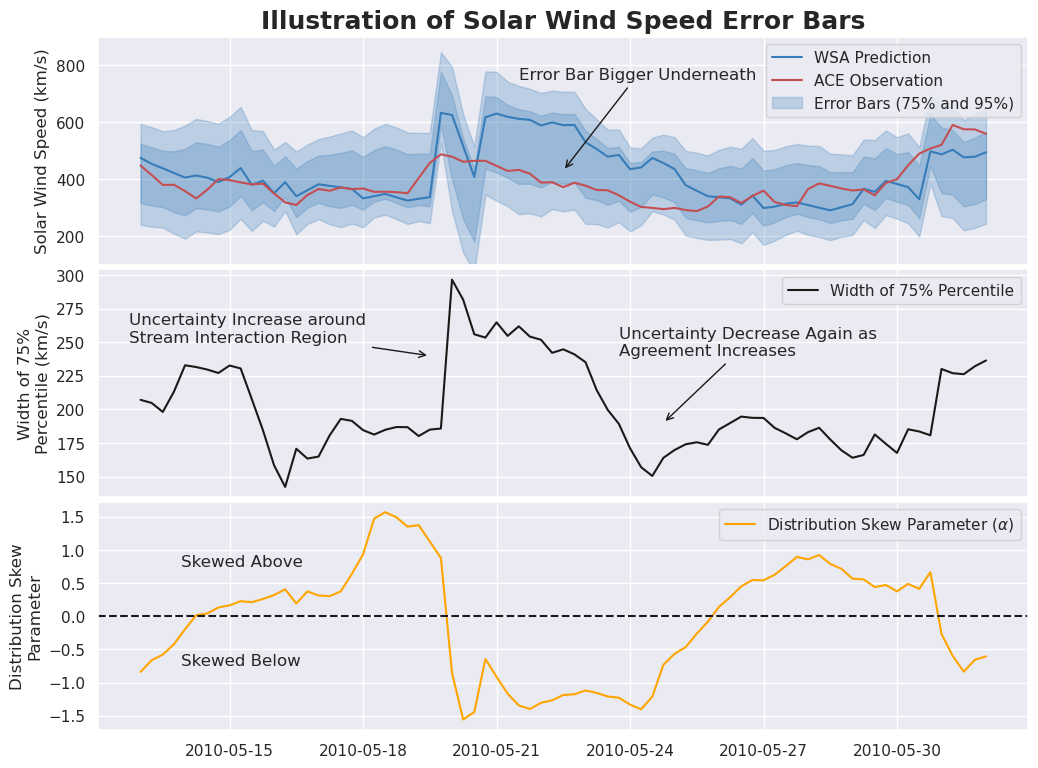

In [128]:
blue_color = "#367cb9"
red_color = "r"
black_color = "k"
gold_color = "orange"
purple_color = "purple"
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 9))

# Error Bars ------------------------------
ax = axes[0]
ax.plot(
    df_dataset["forward_time"],
    df_dataset["forward_Vp_pred"],
    color=blue_color,
    label="WSA Prediction",
)
ax.plot(
    df_dataset["forward_time"],
    df_dataset["forward_Vp_obs"],
    color=red_color,
    label="ACE Observation",
)
ax.fill_between(
    df_dataset["forward_time"],
    err1[:, 0],
    err1[:, 1],
    alpha=0.25,
    color=blue_color,
    label="Error Bars (75% and 95%)",
)
ax.fill_between(
    df_dataset["forward_time"], err2[:, 0], err2[:, 1], alpha=0.25, color=blue_color
)
ax.set_ylabel("Solar Wind Speed (km/s)")
ax.set_yticks([200, 400, 600, 800])
ax.set_ylim(100, 900)

ax.annotate(
    "Error Bar Bigger Underneath",
    xytext=(pd.Timestamp("2010-05-21 12:00:00"), 750),
    xy=(pd.Timestamp("2010-05-22 12:00:00"), 430),
    arrowprops=dict(arrowstyle="->", color="k"),
)

# Scale Parameter ------------------------------
ax = axes[1]
ax.plot(
    df_dataset["forward_time"],
    err1[:, 1] - err1[:, 0],
    color=black_color,
    label="Width of 75% Percentile",
)
ax.set_ylabel("Width of 75%\nPercentile (km/s)")

ax.annotate(
    "Uncertainty Decrease Again as\nAgreement Increases",
    xytext=(pd.Timestamp("2010-05-23 18:00:00"), 240),
    xy=(pd.Timestamp("2010-05-24 18:00:00"), 190),
    arrowprops=dict(arrowstyle="->", color="k"),
)

ax.annotate(
    "Uncertainty Increase around\nStream Interaction Region",
    xytext=(pd.Timestamp("2010-05-12 18:00:00"), 250),
    xy=(pd.Timestamp("2010-05-19 12:00:00"), 240),
    arrowprops=dict(arrowstyle="->", color="k"),
)

# Skew Parameter ------------------------------
ax = axes[2]
ax.plot(
    df_dataset["forward_time"],
    df_dataset["forward_skew"],
    color=gold_color,
    label=r"Distribution Skew Parameter ($\alpha$)",
)
ax.set_ylabel("Distribution Skew\nParameter")
ax.axhline(0, linestyle="dashed", color="k")
ax.text(pd.Timestamp("2010-05-13 22:00:00"), 0.75, "Skewed Above")
ax.text(pd.Timestamp("2010-05-13 22:00:00"), -0.75, "Skewed Below")

for ax in axes:
    ax.legend(loc="upper right")

# i = 500
# print(repr((df_dataset.index[i], df_dataset.index[i + 100])))
#    ax.set_xlim(df_dataset.index[i], df_dataset.index[i + 100])

# plt.xlim(pd.Timestamp('2010-02-25 18:00:00'), pd.Timestamp('2010-03-22 18:00:00'))
axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=3))
axes[0].set_title(
    "Illustration of Solar Wind Speed Error Bars", fontweight="bold", fontsize=18
)
plt.subplots_adjust(wspace=0.4, hspace=0.02)


plt.savefig("../plots/error_bar_illustration.png", dpi=300)

In [117]:
df_dataset

,current_time,forward_time,forward_Vp_pred,forward_Vp_obs,forward_mean,forward_sigma,forward_skew,forward_crps
498,2010-05-10 06:00:00,2010-05-13 00:00:00,475.233333,448.28,0.0,105.149238,-0.840153,27.314170
499,2010-05-10 12:00:00,2010-05-13 06:00:00,454.033333,414.89,0.0,99.297648,-0.662699,29.282699
500,2010-05-10 18:00:00,2010-05-13 12:00:00,438.600000,380.22,0.0,94.019477,-0.578296,35.986275
501,2010-05-11 00:00:00,2010-05-13 18:00:00,422.000000,380.81,0.0,97.533113,-0.423116,29.631380
502,2010-05-11 06:00:00,2010-05-14 00:00:00,406.100000,358.60,0.0,102.439848,-0.195671,32.572317
...,...,...,...,...,...,...,...,...
570,2010-05-28 06:00:00,2010-05-31 00:00:00,487.550000,520.73,0.0,102.233695,-0.267338,28.150229
571,2010-05-28 12:00:00,2010-05-31 06:00:00,503.700000,590.68,0.0,108.206044,-0.596785,51.770127
572,2010-05-28 18:00:00,2010-05-31 12:00:00,477.050000,575.45,0.0,114.688163,-0.835248,58.559321
573,2010-05-29 00:00:00,2010-05-31 18:00:00,479.100000,574.91,0.0,112.381712,-0.657135,57.010349


Text(200, 0.005, 'Location ($\\xi$) = 500 km/s\nScale ($\\omega$) = 100 km/s')

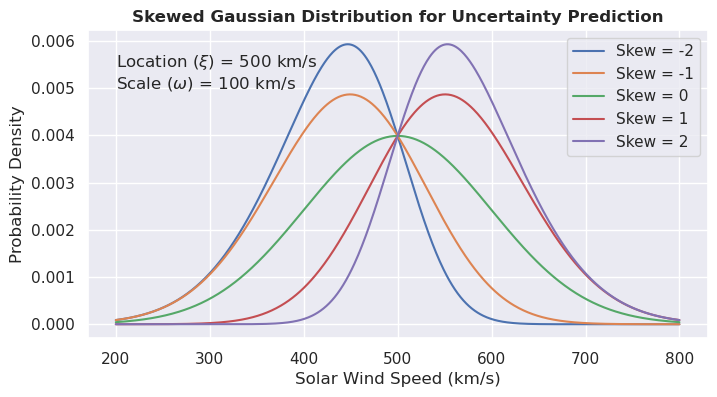

In [118]:
plt.figure(figsize=(8, 4))

bins = np.arange(200, 801, 1)

for skew in [-2, -1, 0, 1, 2]:
    dist = skewnorm(
        skew,
        loc=500,
        scale=100,
    )
    plt.plot(bins, dist.pdf(bins), label=f"Skew = {skew}")

plt.xlabel("Solar Wind Speed (km/s)")
plt.ylabel("Probability Density")
plt.legend()
plt.title("Skewed Gaussian Distribution for Uncertainty Prediction", fontweight="bold")
plt.text(
    200, 0.005, r"Location ($\xi$) = 500 km/s" + "\n" + "Scale ($\omega$) = 100 km/s"
)